# INFORMACIÓN:

- __AUTOR:__ Miguel Puente Ajovín y Maximiliano Greco
- __FECHA:__ Agosto-2015
- __PYTHON:__ 3.k

# INDICE:

- [DATOS](#DATOS)
    - [Número de Regiones y Variables: ](#Número-de-Regiones-y-Variables:)
    - [TASAS CRECIMIENTO](#TASAS-CRECIMIENTO)
    - [INDICES:](#INDICES:)
    - [SERIES FILTRADAS:](#SERIES-FILTRADAS:)
    - [VARIABLES AUXILIARES:](#VARIABLES-AUXILIARES:)


- [CORRELACIÓN:](#CORRELACIÓN:)
    - [RESÚMEN:](#RESÚMEN:)
    - [EXPORTAR:](#EXPORTAR:)



- [OUTLIERS:](#OUTLIERS:)
    - [REESTIMAR:](#REESTIMAR:)
        - [RESÚMEN:](#RESÚMEN:)
        - [EXPORTAR:](#EXPORTAR:)



- [FILTROS](#FILTROS:)
    - [HP](#FILTRO-HP)
        - [MCO HP-FILTER:](#MCO-HP-FILTER:)
    - [QT:](#FILTRO-QT:)

- [EVOLUCIÓN:](#EVOLUCIÓN:)

- [Apéndice:](#Apéndice:)


In [1]:
# python 3, compatibilidad:
# from __future__ import division, unicode_literals, print_function, absolute_import
import os
from datetime import datetime
from numpy import *
import statsmodels.api as sm
# import scipy as sp 

import pandas as pd
from pandas import DataFrame, Series

import matplotlib.pyplot as plt
import seaborn as sns
# import prettyplotlib as ppl

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


# Cambiamos el directorio de trabajo a la raíz

In [2]:
dir_raiz = u'/Users/mmngreco/Documents/repos/okun_ccaa/'
os.chdir(dir_raiz)
UTF = 'utf-8'

!open .

In [3]:
from def_utils import *

In [4]:
sns.set(style="white", color_codes=True)
# sns.set(style="ticks", palette="Set2")
sns.despine()
%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 150)
pd.set_option('display.multi_sparse', False)

In [6]:
hoy = datetime.today()
hoy = str(hoy).replace(' ','_')

[🏠INDICE: ](#INDICE:)

# DATOS

In [42]:
d_tipo = 'indices'
for v in variables:
    globals()['d'+v] = pd.read_excel('data_work/indices/%s.xls' % v, index_col=0)

dparo /= 100

In [43]:
dwork = pd.concat([dempleo, dparo, dpib], keys=variables, axis=1)

/Users/mmngreco/anaconda/envs/py3/lib/python3.4/site-packages/pandas/core/index.py:1428: RuntimeWarning: unorderable types: str() > int(), sort order is undefined for incomparable objects
  "incomparable objects" % e, RuntimeWarning)


In [44]:
dwork.head()

,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib
,España,Andalucía,Aragón,"Asturias, Principado de","Balears, Illes",Canarias,Cantabria,Castilla y León,Castilla - La Mancha,Cataluña,Comunitat Valenciana,Extremadura,Galicia,"Madrid, Comunidad de","Murcia, Región de","Navarra, Comunidad Foral de",País Vasco,"Rioja, La",España,Andalucía,Aragón,"Asturias, Principado de","Balears, Illes",Canarias,Cantabria,Castilla y León,Castilla - La Mancha,Cataluña,Comunitat Valenciana,Extremadura,Galicia,"Madrid, Comunidad de","Murcia, Región de","Navarra, Comunidad Foral de",País Vasco,"Rioja, La",España,Andalucía,Aragón,"Asturias, Principado de","Balears, Illes",Canarias,Cantabria,Castilla y León,Castilla - La Mancha,Cataluña,Comunitat Valenciana,Extremadura,Galicia,"Madrid, Comunidad de","Murcia, Región de","Navarra, Comunidad Foral de",País Vasco,"Rioja, La"
tiempo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1976,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1977,98.962765,98.421573,100.086271,97.054294,100.475004,103.619940,98.443078,96.762971,99.329305,99.292999,99.894981,94.142675,98.027086,99.229413,101.658106,101.430164,99.224823,100.719795,0.051850,0.110725,0.026850,0.037675,0.041350,0.086175,0.035200,0.04235,0.045200,0.038325,0.036600,0.084825,0.018550,0.052425,0.050900,0.03275,0.039475,0.015025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1978,97.420728,97.130121,97.571897,96.249014,100.032749,105.810458,100.375781,95.414827,97.561682,97.927958,99.719317,92.185599,94.950759,95.832786,102.896965,100.234731,96.803784,98.677794,0.069425,0.125175,0.047850,0.051075,0.043575,0.098850,0.044775,0.05275,0.060225,0.061250,0.047600,0.102650,0.025400,0.082900,0.060375,0.05435,0.070925,0.026125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1979,96.079663,96.752329,96.367896,94.066735,101.765769,106.544630,99.809504,94.183789,93.457920,96.780255,100.332859,87.301529,93.348074,93.404236,100.046081,98.703724,94.882858,94.911045,0.086350,0.138450,0.064775,0.073400,0.048300,0.106250,0.054975,0.06725,0.076650,0.079925,0.066425,0.134850,0.034025,0.103775,0.079575,0.08420,0.093575,0.041400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
dwork.tail()

,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib
,España,Andalucía,Aragón,"Asturias, Principado de","Balears, Illes",Canarias,Cantabria,Castilla y León,Castilla - La Mancha,Cataluña,Comunitat Valenciana,Extremadura,Galicia,"Madrid, Comunidad de","Murcia, Región de","Navarra, Comunidad Foral de",País Vasco,"Rioja, La",España,Andalucía,Aragón,"Asturias, Principado de","Balears, Illes",Canarias,Cantabria,Castilla y León,Castilla - La Mancha,Cataluña,Comunitat Valenciana,Extremadura,Galicia,"Madrid, Comunidad de","Murcia, Región de","Navarra, Comunidad Foral de",País Vasco,"Rioja, La",España,Andalucía,Aragón,"Asturias, Principado de","Balears, Illes",Canarias,Cantabria,Castilla y León,Castilla - La Mancha,Cataluña,Comunitat Valenciana,Extremadura,Galicia,"Madrid, Comunidad de","Murcia, Región de","Navarra, Comunidad Foral de",País Vasco,"Rioja, La"
2011,144.840170,158.881044,128.859478,94.721236,204.872106,197.099380,133.318671,108.332675,145.624344,150.877317,152.528942,106.832279,88.431241,185.398932,183.589989,160.248891,126.366610,140.206955,0.216375,0.303875,0.170925,0.178550,0.219625,0.296900,0.152925,0.167350,0.229225,0.192500,0.244875,0.250975,0.174075,0.167300,0.254025,0.129375,0.12005,0.170050,217.208142,226.022890,223.792855,178.832678,255.192868,217.674902,182.156658,183.424283,229.698822,213.875507,212.940831,242.425165,178.205803,263.452847,225.838693,215.812409,175.151596,246.278916
2012,138.638999,150.782122,127.926351,90.326176,207.900451,190.660170,130.053488,104.048391,134.925443,142.640584,145.544883,97.102962,85.009254,180.815934,177.958311,153.645326,119.300915,132.177329,0.250275,0.345925,0.185800,0.217550,0.232625,0.330025,0.177250,0.197400,0.284750,0.226525,0.276550,0.330375,0.206650,0.189875,0.278875,0.162125,0.14880,0.204575,212.619238,219.649636,215.428879,172.709504,253.920720,214.615215,179.006442,177.932538,220.233845,209.745797,206.684211,234.107854,174.217474,262.405320,221.077033,210.020227,172.335088,239.292280
2013,134.771433,146.047580,120.648931,87.192589,209.565487,187.116418,123.527704,99.807244,132.087988,139.764620,142.945748,97.210588,81.702236,174.337720,173.793302,148.263964,115.446074,130.218169,0.263575,0.363375,0.213325,0.240375,0.223800,0.340650,0.205850,0.217375,0.301100,0.233700,0.286125,0.336950,0.220750,0.202375,0.293725,0.181000,0.15835,0.198950,209.997007,217.145858,213.846506,168.387264,252.648572,213.522469,174.929690,174.637491,218.156167,207.354912,205.173992,231.661586,172.585884,258.215215,218.129340,207.874974,169.166516,236.048485
2014,136.380682,149.608844,121.605666,88.821339,212.524767,189.453785,125.310230,100.194245,132.064553,142.651026,145.335299,101.255395,81.022947,174.215231,178.944116,150.762982,114.363813,134.114412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,212.837757,220.104869,217.463360,169.828011,257.482734,218.112000,176.782759,177.200305,220.695551,210.180503,209.273157,236.798748,173.492323,260.834031,222.664253,211.950954,171.278897,242.037030
2015,140.426871,156.697426,127.158924,88.158414,227.103393,198.845949,127.212617,102.006782,132.619998,144.977880,151.280662,103.025223,81.968484,183.069901,176.161344,151.679726,115.212323,135.537911,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
dwork.dropna(axis=0, how='any', inplace=True)

In [47]:
dwork.head()

,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,empleo,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,paro,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib,pib
,España,Andalucía,Aragón,"Asturias, Principado de","Balears, Illes",Canarias,Cantabria,Castilla y León,Castilla - La Mancha,Cataluña,Comunitat Valenciana,Extremadura,Galicia,"Madrid, Comunidad de","Murcia, Región de","Navarra, Comunidad Foral de",País Vasco,"Rioja, La",España,Andalucía,Aragón,"Asturias, Principado de","Balears, Illes",Canarias,Cantabria,Castilla y León,Castilla - La Mancha,Cataluña,Comunitat Valenciana,Extremadura,Galicia,"Madrid, Comunidad de","Murcia, Región de","Navarra, Comunidad Foral de",País Vasco,"Rioja, La",España,Andalucía,Aragón,"Asturias, Principado de","Balears, Illes",Canarias,Cantabria,Castilla y León,Castilla - La Mancha,Cataluña,Comunitat Valenciana,Extremadura,Galicia,"Madrid, Comunidad de","Murcia, Región de","Navarra, Comunidad Foral de",País Vasco,"Rioja, La"
1980,93.465515,92.927827,93.771202,92.292505,98.980529,105.050183,97.611387,93.029685,90.161129,93.578697,96.685998,86.315556,90.329595,93.037726,94.555719,95.762477,92.217320,95.191726,0.114150,0.174100,0.086175,0.084075,0.080100,0.123225,0.074700,0.084500,0.106575,0.122325,0.097100,0.149875,0.050125,0.125350,0.098225,0.118700,0.123775,0.051975,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1981,91.058134,91.183527,90.672381,89.363463,95.049024,101.283297,95.745806,91.172635,87.228499,91.068169,92.298128,85.360899,88.163908,92.042630,91.887880,93.745358,89.228981,93.141806,0.140300,0.197950,0.117900,0.117525,0.099725,0.162275,0.103125,0.103725,0.139500,0.153950,0.133325,0.165075,0.061200,0.143525,0.125500,0.130300,0.157150,0.074525,99.823614,98.543003,97.653772,101.121621,103.640682,100.942174,101.358970,94.519104,96.239223,98.908545,102.764928,96.928557,101.226780,100.694282,101.074916,103.254464,101.394926,104.012676
1982,90.218963,91.532938,91.229616,85.607570,94.418912,99.593609,90.018992,89.390048,88.986436,88.112648,90.406271,85.194632,88.326580,93.867227,92.494977,93.677619,87.034000,90.916845,0.158450,0.205375,0.122125,0.137075,0.117450,0.182175,0.124175,0.121575,0.137325,0.191550,0.167650,0.173825,0.075200,0.145000,0.152850,0.133800,0.181650,0.109950,101.386883,101.744929,102.640118,102.884169,106.950896,101.390224,103.320681,98.148072,97.001480,97.897669,102.908031,97.543822,103.160722,103.817334,100.539416,102.002919,103.713466,108.180656
1983,89.750160,91.493362,91.115750,85.004760,96.955407,101.442928,89.204198,88.735719,89.942407,85.630517,90.698133,87.999335,88.850490,92.812809,89.627896,92.825040,86.367822,89.523369,0.173275,0.224125,0.136825,0.138950,0.139275,0.191100,0.126075,0.135575,0.140825,0.210750,0.172675,0.163475,0.098900,0.167025,0.166225,0.155175,0.196150,0.112600,103.637180,103.854292,106.332517,104.352662,112.640726,105.446910,106.203071,102.156185,97.529342,99.711271,104.965355,100.433898,103.643150,107.482462,102.605513,104.163198,103.240445,111.995715
1984,87.371813,84.647889,87.999507,82.547703,97.932792,100.274291,88.199671,86.246936,87.592835,84.971253,89.480471,76.704382,87.831342,91.364489,91.943788,90.387822,85.032712,82.969340,0.200800,0.289050,0.151900,0.156600,0.140475,0.223525,0.159850,0.159875,0.162750,0.217375,0.194900,0.265225,0.116050,0.193875,0.168600,0.162300,0.216025,0.138225,105.157809,104.816762,111.142113,105.434923,119.007040,101.968225,107.652671,104.553093,100.763198,101.817115,107.146900,115.913513,104.537362,108.649879,103.536594,103.837079,100.038474,114.647124


- [mco](#RESÚMEN)

[🏠INDICE: ](#INDICE:)

## VARIABLES AUXILIARES:

In [5]:
variables = ['empleo', 'paro', 'pib']
regiones = dwork['empleo'].columns # variable con los nombres de las ccaa
foot = u'FUENTE: Datos obtenidos de la web: INE.es, \nElaboración propia: Maximiliano Greco, @mmngreco' 

[🏠INDICE: ](#INDICE:)

In [49]:
# con matplotlib
# fig = plt.figure(figsize=(15,15))
# data.du.boxplot(rot=90, ax=fig.add_subplot(311))
# data.dl.boxplot(rot=90, ax=fig.add_subplot(312))
# data.dy.boxplot(rot=90, ax=fig.add_subplot(313))

# plt.tight_layout()

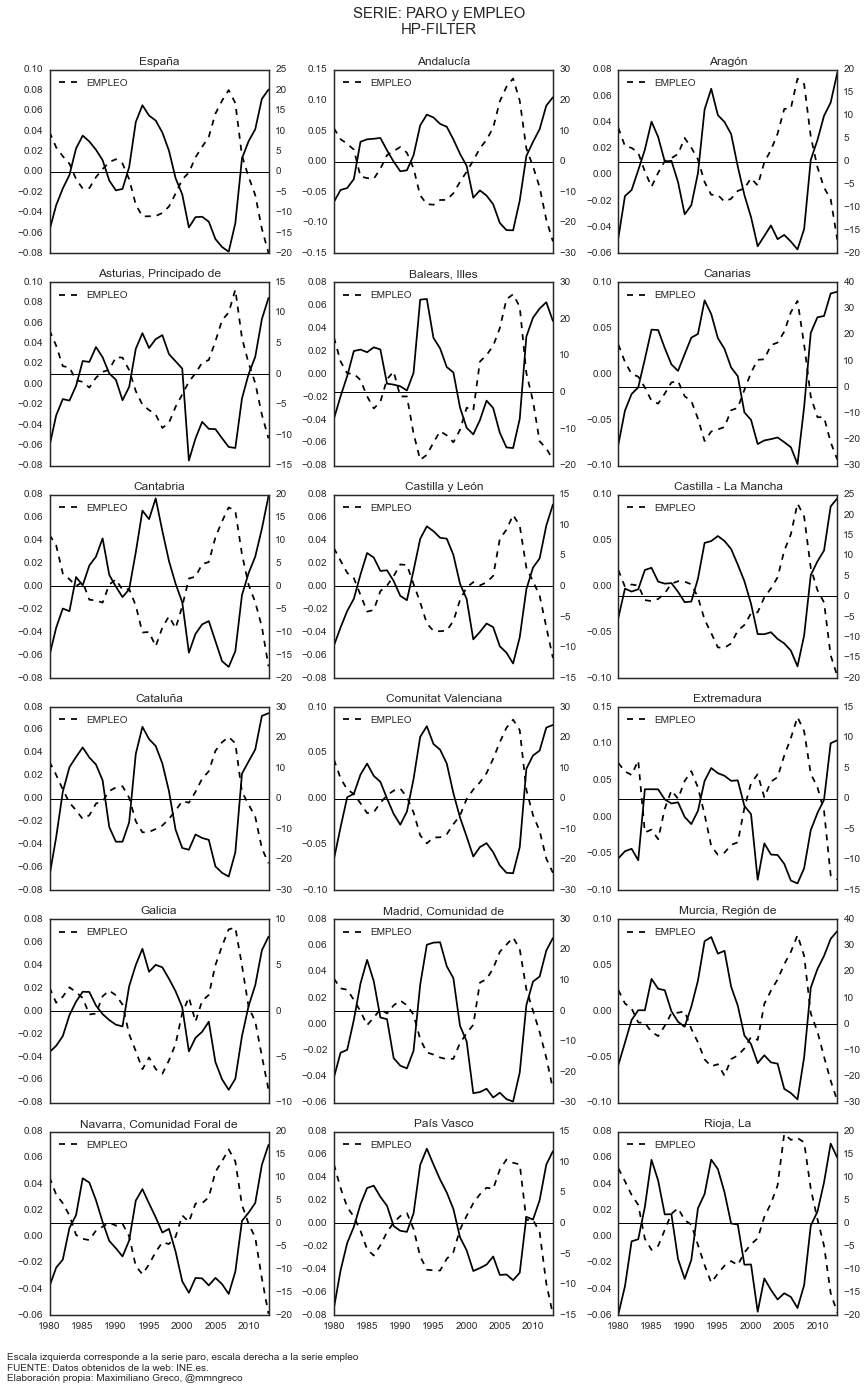

In [82]:
# PARAMETROS DEL GRÁFICO
id_x = 0
data = hps
d_tipo = 'hp-filter'
x = ['paro', 'empleo']
foot1 = '''Escala izquierda corresponde a la serie %s, escala derecha a la serie %s
FUENTE: Datos obtenidos de la web: INE.es.
Elaboración propia: Maximiliano Greco, @mmngreco''' % (variables[1], variables[0])

c = 'black'
ttl = 'SERIE: %s y %s\n%s' % (x[0].upper(), x[1].upper(), d_tipo.upper())
file_name = 'serie_%s_%s_%s_%s.png' % (x[0], x[1], d_tipo.upper(), hoy)

######## 

fig = plt.figure(figsize=(12,18))

for i, reg in enumerate(regiones):
    ax = fig.add_subplot(len(regiones)/3, 3, i + 1)
    data[x[0]][reg].plot(ax=ax, label=x[0].upper(), color=c, sharex=True)
    data[x[1]][reg].plot(ax=ax, linestyle='--', label=x[1].upper(), secondary_y=True, color=c, sharex=True)
    plt.axhline(y=0, color='black', linewidth=1, axes=ax)
    plt.title(reg)
    plt.legend(loc='upper left')

plt.gcf().text(0, -0.03, "%s" % foot1, fontsize=10, transform=(1,1))
plt.tight_layout()
plt.suptitle(t=ttl, fontsize=15, x=0.5, y=1.03)
plt.savefig('imgs/%s' % file_name, bbox_inches='tight', dpi=200)

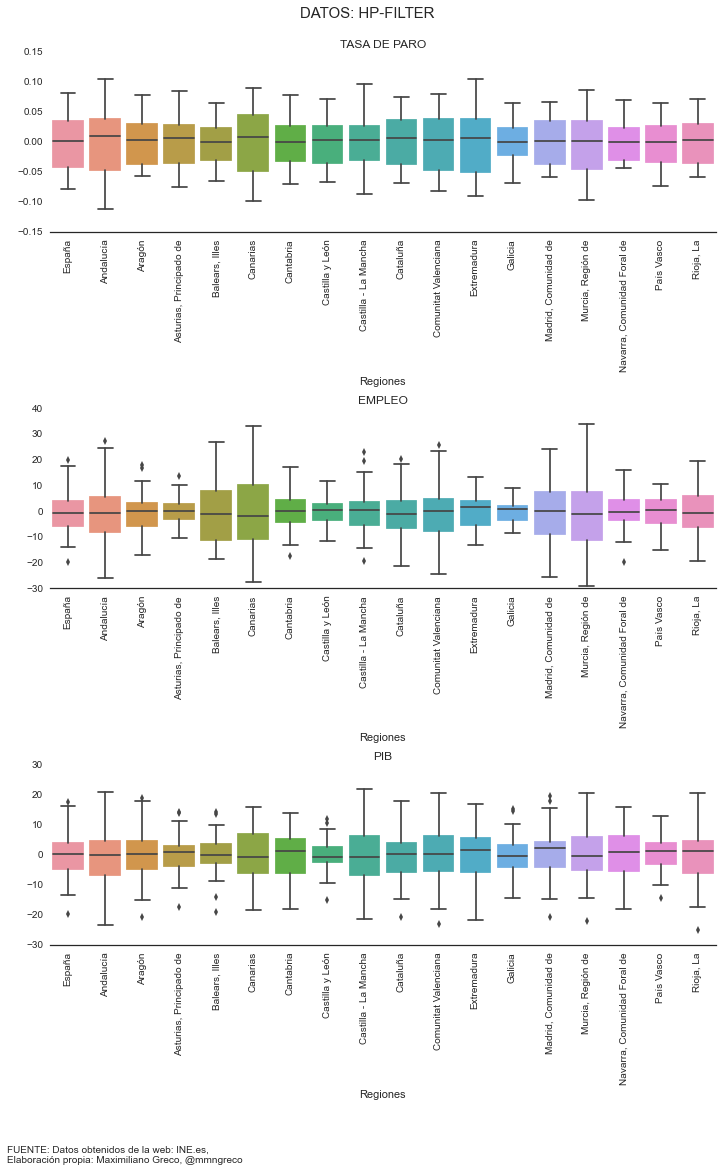

In [83]:
# i = id_xls
ttl = 'DATOS: %s' % (d_tipo.upper())
file_name = 'boxplot_%s_%s.png' % (d_tipo.upper(), hoy)


# con seaborn
fig = plt.figure(figsize=(10,15))
sns.set_palette('Greys')

g1 = sns.boxplot(data=data.paro, fliersize=5, width=.8, ax=fig.add_subplot(311))
g1.set_xticklabels(data.paro.columns, rotation=90)
g1.set_title('TASA DE PARO')

g2 = sns.boxplot(data=data.empleo, fliersize=5, width=.8, ax=fig.add_subplot(312))
g2.set_xticklabels(data.empleo.columns, rotation=90)
g2.set_title('EMPLEO')

g3 = sns.boxplot(data=data.pib, fliersize=5, width=.8, ax=fig.add_subplot(313))
g3.set_xticklabels(data.pib.columns, rotation=90)
g3.set_title('PIB')

sns.despine(left=True)

plt.suptitle(x=0.5, y=1.02, t=ttl, fontsize=15)
plt.gcf().text(0, -0.05, "%s" % foot, fontsize=10, transform=(1,1))
plt.tight_layout()

plt.savefig('imgs/%s' % file_name, bbox_inches='tight', dpi=150)

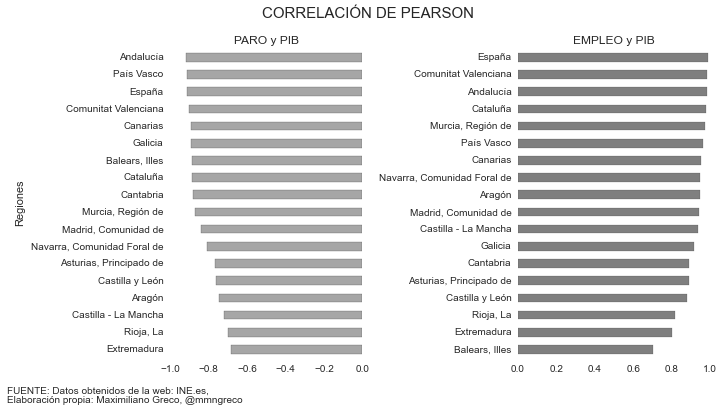

In [84]:
ttl = 'CORRELACIÓN DE PEARSON\n%s' % d_tipo.upper()
file_name = 'corr_%s_%s.png' % (d_tipo.upper(), hoy)

x = ['paro', 'empleo']
y = 'pib'

# ----------------------------

plt.figure(figsize=(10,5))

axs = [plt.subplot(121)]
data[x[0]].corrwith(data[y], axis=0).order(ascending=False).plot(kind='barh', color='grey', alpha=0.7)
plt.gca().set_title('%s y %s' % (x[0].upper(), y.upper()))

axs += [plt.subplot(122)]
data[x[1]].corrwith(data[y], axis=0).order(ascending=True).plot(kind='barh', color='black', alpha=0.5)
plt.gca().set_title('%s y %s' % (x[1].upper(), y.upper()))

plt.suptitle('CORRELACIÓN DE PEARSON', fontsize=15, x=0.5, y=1.05)

# Quitar las líneas del marco del eje.

for i, ax in enumerate(axs):
    if i == 1:
        ax.axes.get_yaxis().set_visible(True)
        ax.tick_params(labelleft='off')
        plt.ylabel('')
        ax.yaxis.tick_right()
    else:
        ax.axes.get_yaxis().set_visible(True)

    ax.spines["top"].set_visible(False)  
    ax.spines["bottom"].set_visible(False)  
    ax.spines["right"].set_visible(False)  
    ax.spines["left"].set_visible(False)  

    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

    ax.axes.get_xaxis().set_visible(True)

    ax.tick_params(axis='both',
                   which='both',
                   bottom='off',
                   top='off',
                   left='off',
                   labelbottom='on')

    
plt.gcf().text(0, -0.05, "%s" % foot, fontsize=10, transform=(1,1))
plt.tight_layout()
plt.savefig('imgs/%s' % file_name, bbox_inches='tight', dpi=150)

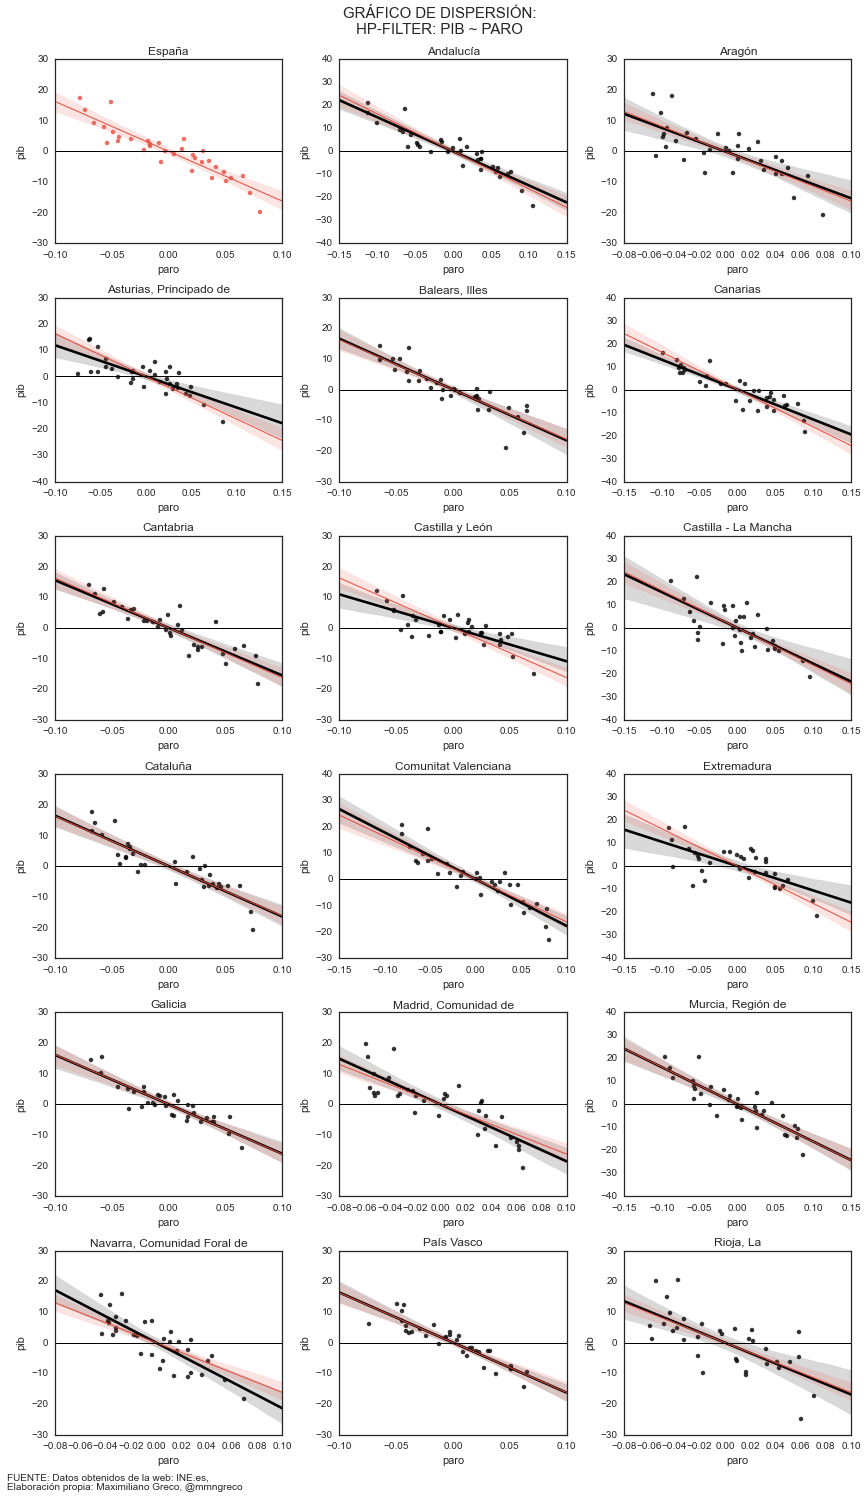

In [87]:
# PARAMETROS DEL GRÁFICO
id_x = 0
x = ['paro', 'empleo']
y = 'pib'

ttl = 'GRÁFICO DE DISPERSIÓN: \n%s: %s ~ %s' % (d_tipo.upper(), y.upper(), x[id_x].upper())
file_name = 'reg%s_%s_%s_%s.png' % (x[id_x].upper(), y.upper(), d_tipo, hoy)


######## 

fig = plt.figure(figsize=(12,20))

for i, reg in enumerate(regiones):
    if reg == 'España':
        ax = fig.add_subplot(len(regiones)/3, 3, i + 1)
        g = sns.regplot(y=data[y][reg], x=data[x[id_x]][reg], ax=ax, color="#e74c3c", line_kws={'linewidth': 1})
        plt.axhline(y=0, color='black', linewidth=1)

    else:
        ax = fig.add_subplot(len(regiones)/3, 3, i + 1)
        g = sns.regplot(y=data[y][reg], x=data[x[id_x]][reg], ax=ax, color='black')
        sns.regplot(y=data[y]['España'], 
                    x=data[x[id_x]]['España'], 
                    ax=ax, 
                    color="#e74c3c", 
                    scatter=False, 
                    line_kws={'linewidth': 1})
        plt.axhline(y=0, color='black', linewidth=1)
    g.set_xlabel(x[id_x])
    g.set_ylabel(y)
    g.set_title(reg)

plt.gcf().text(0, -0.01, "%s" % foot, fontsize=10, transform=(1,1))
plt.tight_layout()
plt.suptitle(t=ttl, fontsize=15, x=0.5, y=1.02)

plt.savefig('imgs/%s' % file_name, bbox_inches='tight', dpi=150)

[🏠INDICE: ](#INDICE:)

# RESÚMEN

In [63]:
# Fit and summarize OLS model
id_x = 0
x = ['paro', 'empleo']
y = 'pib'
v = x[id_x]

In [89]:
s, p, m = estimar_mco(data, exogena=v, endogena=y, regiones=regiones)
print(d_tipo)
resumen_mco(p, 1)

hp-filter


,$β_0$,$pv_{β_0}$,$β_1$,$pv_{β_1}$,$R^2$
Extremadura,-2.622957e-11,1,-105.847983,9.222929e-06,0.464056
"Rioja, La",-2.740125e-11,1,-169.120329,4.622686e-06,0.486038
Castilla - La Mancha,-1.848932e-11,1,-155.578722,1.690514e-06,0.516533
Aragón,-2.465134e-11,1,-153.124490,3.721574e-07,0.559185
Castilla y León,-2.092582e-11,1,-109.075060,1.455934e-07,0.583790
"Asturias, Principado de",-2.231398e-11,1,-118.599259,1.185217e-07,0.589004
"Navarra, Comunidad Foral de",-1.614964e-11,1,-214.004848,6.677335e-09,0.655579
"Madrid, Comunidad de",-2.655454e-11,1,-185.743169,4.593239e-10,0.707993
"Murcia, Región de",-2.192935e-11,1,-161.639137,1.817998e-11,0.760868
Cantabria,-2.601636e-11,1,-155.130199,6.675493e-12,0.775261


[🏠INDICE: ](#INDICE:)

# EXPORTAR:

In [27]:
# guardar_mco(sumrz_paro, 'modelos_u')

# guardar_mco(sumrz_empleo, 'modelos_l')

[🏠INDICE: ](#INDICE:)

# FILTROS:

[DATOS](#DATOS)

## FILTRO HP

In [51]:
#for i in range(5):

id_x = 1  
#               0         1        2  # variable a filtrar
variables = ['empleo', 'paro', 'pib']

print('{:^60}'.format('FILTRO HP'))
print('HOJA %s' % d_tipo)

data = dwork.copy()

print('Desde: ',data.index[0], 'Hasta:', data.index[-1])
print('Obs.:', len(data.index))

for v in variables:
    d = data[v]
    d = d.dropna(axis=0)

    ciclo, tendencia = sm.tsa.filters.hpfilter(d)
    globals()['hp_%s' % v] = ciclo # variable output
    print('Variable sin tendencia HP creada: %s' % ('hp_%s' % v))
    print(ciclo.head().ix[:,:4])
    ciclo.to_excel('hp_{}_{}_{}.xls'.format(v, d.index[0], d.index[-1]))
    print('Desde: ',d.index[0], 'Hasta:', d.index[-1])
    print('Obs.:', len(d.index))
    print('')

                         FILTRO HP                          
HOJA indices
Desde:  1980 Hasta: 2013
Obs.: 34
Variable sin tendencia HP creada: hp_empleo
        España  Andalucía    Aragón  Asturias, Principado de
1980  9.749476  10.908162  7.396422                 7.137203
1981  6.001890   7.321642  3.368380                 4.620609
1982  3.816419   5.822016  2.991771                 1.272704
1983  1.985379   3.915192  1.932710                 1.066073
1984 -1.783373  -4.830773 -2.148676                -1.014759
Desde:  1980 Hasta: 2013
Obs.: 34

Variable sin tendencia HP creada: hp_paro
        España  Andalucía    Aragón  Asturias, Principado de
1980 -0.057198  -0.065870 -0.048326                -0.060606
1981 -0.032784  -0.046333 -0.016261                -0.030677
1982 -0.016334  -0.043180 -0.011667                -0.014610
1983 -0.003117  -0.028591  0.003473                -0.016123
1984  0.022958   0.032381  0.019107                -0.001700
Desde:  1980 Hasta: 2013
Obs.: 34

Vari

[🏠INDICE: ](#INDICE:)

# FILTRO QT:

[DATOS](#DATOS)

[🏠INDICE: ](#INDICE:)

In [63]:

for i in range(3):
    id_v = i
    v = variables[id_v]

    file_name= 'qt_%s_%s' % (v, hoy)
    
    data = crear_df([dempleo, dparo, dpib], 
                    keys=['empleo', 'paro', 'pib'])

    d = data[v]
    d.dropna(axis=0, inplace=True, how='any')
    globals()['qt_%s' % v] = sm.tsa.tsatools.detrend(d, order=2, axis=0)
    df = globals()['qt_%s' % v]

    globals()['qt_%s' % v] = DataFrame(df, index=d.index, columns=d.columns)
    print('Variable sin tendencia creada: qt_%s' % v)

    df = globals()['qt_%s' % v]

    df.to_excel('data_work/filtrado/%s.xls' % file_name, encoding=UTF)
    print(df.head().ix[:,:2])


/Users/mmngreco/anaconda/envs/py3/lib/python3.4/site-packages/pandas/core/index.py:1428: RuntimeWarning: unorderable types: str() > int(), sort order is undefined for incomparable objects
  "incomparable objects" % e, RuntimeWarning)
/Users/mmngreco/anaconda/envs/py3/lib/python3.4/site-packages/IPython/kernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Variable sin tendencia creada: qt_empleo
Regiones     España  Andalucía
1976      11.157807  13.816008
1977       9.650252  11.272826
1978       7.567945   8.944374
1979       5.616660   7.457338
1980       2.322342   2.451347
Variable sin tendencia creada: qt_paro
Regiones    España  Andalucía
1977     -0.070249  -0.063234
1978     -0.057640  -0.058064
1979     -0.045449  -0.053609
1980     -0.022153  -0.026317
1981     -0.000275  -0.010365
Variable sin tendencia creada: qt_pib
Regiones     España  Andalucía
1980      10.765287  12.650768
1981       6.156856   6.042734
1982       3.303453   4.131860
1983       1.152452   1.166662
1984      -1.712845  -2.907192


In [64]:
qt_pib.head(2)

Regiones,España,Andalucía,Aragón,"Asturias, Principado de","Balears, Illes",Canarias,Cantabria,Castilla y León,Castilla - La Mancha,Cataluña,Comunitat Valenciana,Extremadura,Galicia,"Madrid, Comunidad de","Murcia, Región de","Navarra, Comunidad Foral de",País Vasco,"Rioja, La"
1980,10.765287,12.650768,8.513183,5.145072,11.086771,13.705288,8.323998,8.363751,11.087250,15.676334,11.418722,9.519137,5.354588,9.107500,11.338225,8.633942,6.651759,10.483963
1981,6.156856,6.042734,1.537690,2.688861,6.806208,9.520368,5.974302,-0.796264,3.327942,9.583123,9.378726,0.673434,4.391741,4.904481,8.598402,8.146129,5.940283,8.442287


In [74]:
id_x = 0
x = ['paro', 'empleo']
y = 'pib'
v = x[id_x]

d = crear_df([qt_empleo, qt_paro, qt_pib])
s, b, m = estimar_mco(d, 
                      endogena=v, 
                      exogena=y, 
                      regiones=regiones)

res = resumen_mco(b, 0)
#print(res.describe().ix[[0,1,2,3,7],:].T)

res

,b0,pv_b0,b1,pv_b1,R2
Extremadura,0.006082,0.463633,-0.004690,2.074219e-05,0.437142
Castilla - La Mancha,0.006900,0.315909,-0.003332,2.004125e-05,0.438308
"Rioja, La",0.006256,0.311400,-0.002964,1.985886e-05,0.438618
Aragón,0.006900,0.267803,-0.003588,1.660539e-05,0.444651
"Navarra, Comunidad Foral de",0.007363,0.162254,-0.002991,1.188709e-05,0.455761
"Asturias, Principado de",0.005874,0.319621,-0.005216,1.113665e-06,0.528674
Castilla y León,0.005237,0.321162,-0.005711,7.453788e-07,0.540079
Cataluña,0.009561,0.133337,-0.004400,2.842690e-07,0.566388
"Madrid, Comunidad de",0.007111,0.192008,-0.003635,7.180557e-08,0.601440
País Vasco,0.007695,0.126613,-0.004913,2.437256e-08,0.627025


# EVOLUCIÓN:

In [101]:
d_tipo = 'qt-filter'
data = qts

desde = data.index.min()
hasta = desde + 10
fin = data.index.max()

id_x = 0 

y = variables[-1]
x = variables[id_x]

print('VARIABLE:', y.upper(), '~', x.upper())
print('ESTIMACIÓN:\n    Desde:\t%s\n    Hasta:\t%s\n    Fin:\t%s\nAñadiendo un año más a la muestra.' % (desde, hasta, fin))

b0_evolucion = DataFrame(columns=regiones)
b1_evolucion = DataFrame(columns=regiones)
# umbral_evolucion = DataFrame(columns=regiones)


while hasta <= fin:
    s, p, m = estimar_mco(data.iloc[:hasta - desde + 1], 
                          endogena=y, 
                          exogena=x, 
                          regiones=regiones)

    b0_evolucion.loc[hasta] = resumen_mco(p, 0).b0.T
    b1_evolucion.loc[hasta] = resumen_mco(p, 0).b1.T

    if hasta == 2004: 
        print('MCO 2004:\n')
        print(resumen_mco(p, 0)[['b0', 'b1']])

    hasta += 1

evolucion_okun = crear_df([b0_evolucion, b1_evolucion], keys=['b0', 'b1'])
evolucion_okun.head()

/Users/mmngreco/anaconda/envs/py3/lib/python3.4/site-packages/statsmodels/stats/stattools.py:72: UserWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  "samples were given." % int(n))
/Users/mmngreco/anaconda/envs/py3/lib/python3.4/site-packages/scipy/stats/stats.py:1277: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))
/Users/mmngreco/anaconda/envs/py3/lib/python3.4/site-packages/scipy/stats/stats.py:1277: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))
/Users/mmngreco/anaconda/envs/py3/lib/python3.4/site-packages/scipy/stats/stats.py:1277: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))
/Users/mmngreco/anaconda/envs/py3/lib/python3.4/site-packages/scipy/stats/stats.py:1277: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))
/Users/mmngrec

VARIABLE: PIB ~ EMPLEO
ESTIMACIÓN:
    Desde:	1976
    Hasta:	1986
    Fin:	2015
Añadiendo un año más a la muestra.
MCO 2004:

                                   b0        b1
Extremadura                 -0.523517  0.497309
Rioja, La                    0.401758  0.615911
Castilla y León              0.124894  0.625509
Balears, Illes               0.679116  0.414536
Galicia                     -0.080050  0.846416
Castilla - La Mancha         0.880327  0.898453
Navarra, Comunidad Foral de  1.068268  0.815386
País Vasco                   0.626755  0.698880
Aragón                       0.675309  0.869339
Cataluña                     1.141653  0.713110
Asturias, Principado de      0.504287  1.008669
Madrid, Comunidad de         0.717261  0.645440
Murcia, Región de            1.196665  0.602185
España                       0.939663  0.769757
Andalucía                    1.104029  0.725871
Cantabria                    1.341185  0.944360
Canarias                     0.973795  0.504320
Comunitat

/Users/mmngreco/anaconda/envs/py3/lib/python3.4/site-packages/scipy/stats/stats.py:1277: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


Variables,b0,b0,b0,b0,b0,b0,b0,b0,b0,b0,b0,b0,b0,b0,b0,b0,b0,b0,b1,b1,b1,b1,b1,b1,b1,b1,b1,b1,b1,b1,b1,b1,b1,b1,b1,b1
Regiones,España,Andalucía,Aragón,"Asturias, Principado de","Balears, Illes",Canarias,Cantabria,Castilla y León,Castilla - La Mancha,Cataluña,Comunitat Valenciana,Extremadura,Galicia,"Madrid, Comunidad de","Murcia, Región de","Navarra, Comunidad Foral de",País Vasco,"Rioja, La",España,Andalucía,Aragón,"Asturias, Principado de","Balears, Illes",Canarias,Cantabria,Castilla y León,Castilla - La Mancha,Cataluña,Comunitat Valenciana,Extremadura,Galicia,"Madrid, Comunidad de","Murcia, Región de","Navarra, Comunidad Foral de",País Vasco,"Rioja, La"
1986,7.084572,7.050249,4.743939,2.516099,5.130701,6.722637,3.414350,2.287227,9.139907,10.806473,8.185634,-0.552331,1.881529,5.267676,9.019175,7.089644,6.419386,6.304131,1.259024,0.978671,0.875086,0.898503,1.110717,1.073220,1.220522,0.640886,2.571941,1.370272,1.067337,-0.185378,0.440734,0.972890,1.126699,1.319437,0.938754,0.831800
1987,6.892816,6.956059,3.841012,2.550827,5.165963,6.817380,3.182227,2.353883,8.023963,9.943695,7.916801,-0.274944,1.757924,5.330209,8.775134,7.170241,6.382353,4.936522,1.283441,0.990914,0.814086,0.895302,1.082758,1.055909,1.369294,0.638901,2.388258,1.382472,1.096942,-0.191250,1.072382,0.971026,1.151998,1.302818,0.998579,0.943746
1988,6.384080,6.275328,3.542224,2.711534,3.912881,6.707416,3.414676,2.407411,6.293186,9.121621,7.185568,0.840761,0.960018,5.459552,6.627196,7.028366,5.994575,2.831089,1.251235,0.945898,0.780400,0.918750,0.933467,1.055496,1.205216,0.643630,1.979724,1.359836,1.067291,-0.086468,0.509705,0.950648,0.946724,1.305600,1.002601,0.816048
1989,5.606876,5.203027,3.781812,3.013555,1.847324,6.606791,3.881597,2.546379,6.448749,7.316352,6.157504,1.431112,0.995576,5.423973,5.506916,7.520218,5.795539,0.710518,1.156388,0.848399,0.816860,0.982060,0.572849,1.053150,1.216760,0.669366,2.018591,1.203488,0.982047,-0.045743,0.540326,0.947420,0.830554,1.335329,0.986939,0.610742
1990,4.844480,4.601303,3.342819,2.203822,1.855354,6.607194,3.757990,2.298433,6.367712,5.985737,5.257532,1.753659,0.654516,4.817110,5.327512,7.881668,5.173348,1.257777,1.047608,0.781802,0.721931,0.695706,0.571973,1.053039,1.204280,0.607019,1.997988,1.069428,0.891304,-0.000718,0.283917,0.859209,0.809832,1.353787,0.917719,0.629528


In [102]:
evolucion_okun.tail()

Variables,b0,b0,b0,b0,b0,b0,b0,b0,b0,b0,b0,b0,b0,b0,b0,b0,b0,b0,b1,b1,b1,b1,b1,b1,b1,b1,b1,b1,b1,b1,b1,b1,b1,b1,b1,b1
Regiones,España,Andalucía,Aragón,"Asturias, Principado de","Balears, Illes",Canarias,Cantabria,Castilla y León,Castilla - La Mancha,Cataluña,Comunitat Valenciana,Extremadura,Galicia,"Madrid, Comunidad de","Murcia, Región de","Navarra, Comunidad Foral de",País Vasco,"Rioja, La",España,Andalucía,Aragón,"Asturias, Principado de","Balears, Illes",Canarias,Cantabria,Castilla y León,Castilla - La Mancha,Cataluña,Comunitat Valenciana,Extremadura,Galicia,"Madrid, Comunidad de","Murcia, Región de","Navarra, Comunidad Foral de",País Vasco,"Rioja, La"
2011,0.694200,0.794238,0.793228,0.350976,0.442176,0.712808,0.356056,0.440738,0.624839,0.879173,0.863940,0.807193,0.475030,0.603589,0.893687,0.749125,0.734505,0.739015,0.732478,0.679797,0.866975,0.974686,0.405989,0.471357,0.748275,0.754309,0.833057,0.687033,0.711104,0.835688,1.165279,0.642820,0.564056,0.778541,0.763399,0.704697
2012,0.586848,0.673090,0.542152,0.276911,0.348757,0.594083,0.220244,0.337392,0.493888,0.769812,0.725618,0.745384,0.316457,0.526657,0.742733,0.604801,0.636232,0.570968,0.743241,0.689893,0.889060,0.986539,0.413049,0.478545,0.759569,0.769243,0.846119,0.698402,0.723054,0.848717,1.192047,0.647605,0.573063,0.793647,0.775319,0.722376
2013,0.450735,0.549635,0.408996,0.166455,0.211546,0.466263,0.128237,0.213743,0.314529,0.624778,0.584067,0.552197,0.171244,0.358722,0.517543,0.487942,0.491647,0.325311,0.763960,0.704851,0.916100,1.015592,0.426495,0.489430,0.775377,0.803162,0.872028,0.719478,0.739094,0.894050,1.237120,0.666309,0.592671,0.815699,0.805427,0.756988
2014,0.343899,0.428558,0.334551,0.072169,0.207017,0.416933,0.078896,0.155308,0.178861,0.493775,0.502566,0.374275,0.042165,0.217530,0.305548,0.404933,0.409700,0.178079,0.781493,0.719567,0.932524,1.040283,0.427025,0.493975,0.784542,0.820690,0.895061,0.738639,0.748663,0.928006,1.284357,0.685336,0.610984,0.831985,0.826595,0.777489
2015,0.343899,0.428558,0.334551,0.072169,0.207017,0.416933,0.078896,0.155308,0.178861,0.493775,0.502566,0.374275,0.042165,0.217530,0.305548,0.404933,0.409700,0.178079,0.781493,0.719567,0.932524,1.040283,0.427025,0.493975,0.784542,0.820690,0.895061,0.738639,0.748663,0.928006,1.284357,0.685336,0.610984,0.831985,0.826595,0.777489


[🏠INDICE: ](#INDICE:)

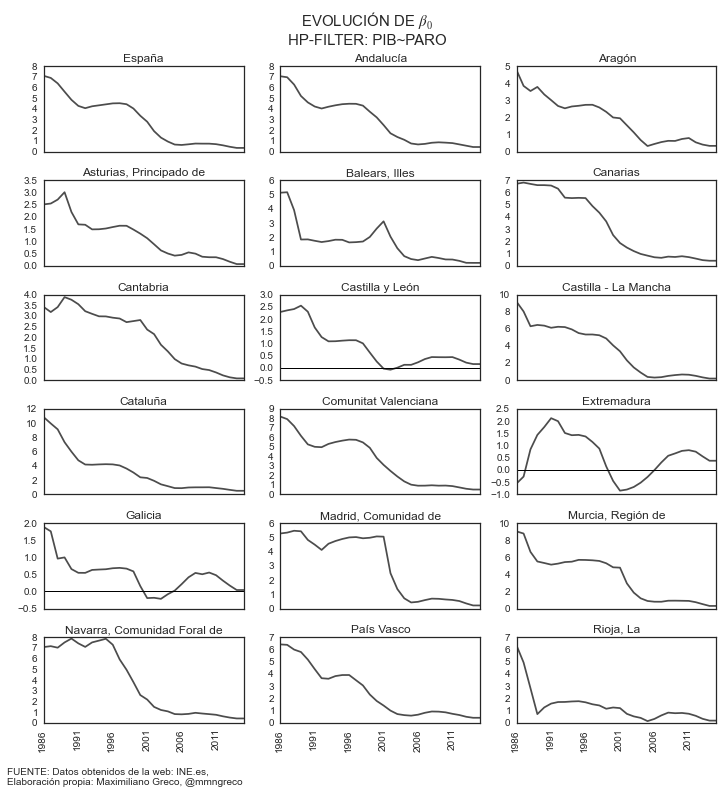

In [105]:
fig = plt.figure(figsize=(10,10))
x = 'paro'
y = 'pib'
p = 'b0'
d_tipo = 'hp-filter'
ttl= 'EVOLUCIÓN DE $β_%s$\n%s: %s~%s' % (p[-1],d_tipo.upper(), y.upper(), x.upper())
file_name = 'evolucion_%s_%s_%s_%s.png' % (d_tipo, y, p, hoy)

for i, reg in enumerate(regiones):
    ax = fig.add_subplot(6,3,i+1)
    plt.axhline(y=0, color='black', linewidth=1)
    evolucion_okun[p][reg].plot(ax=ax, label=reg, sharex=True, color='black', alpha=0.7)
    plt.title(reg)
    plt.xticks(evolucion_okun.index[::5], evolucion_okun.index[::5], rotation=90)
    plt.xlim(evolucion_okun.index.min(), evolucion_okun.index.max())

plt.gcf().text(0, -0.03, "%s" % foot, fontsize=10, transform=(1,1))
plt.suptitle(x=0.5, y=1.05, t=ttl, fontsize=15)
plt.tight_layout()
plt.savefig('imgs/%s' % file_name, bbox_inches='tight', dpi=150)

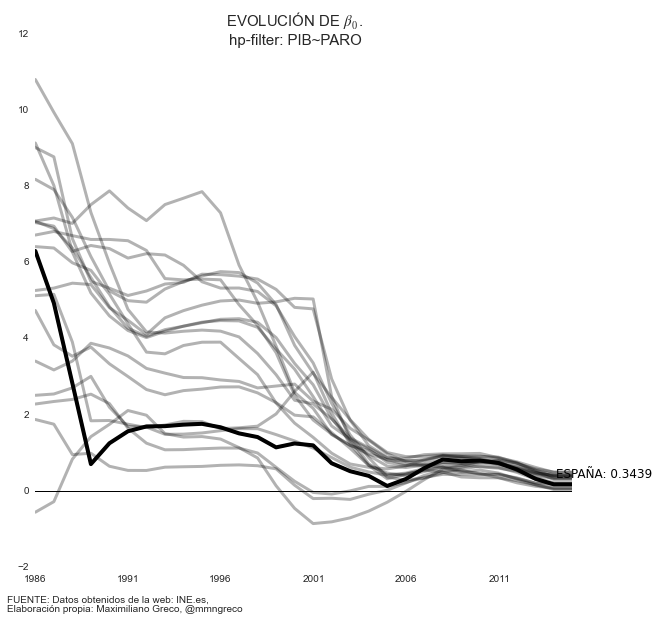

In [104]:
p = 'b0'
fig = plt.figure(figsize=(8,8), dpi=200)
x = 'paro'
y = 'pib'
ttl= 'EVOLUCIÓN DE $β_%s$.\n%s: %s~%s' % (p[-1],d_tipo, y.upper(), x.upper())
file_name = 'evolucion_%s_%s_%s_%s_todas.png' % (d_tipo, y, p, hoy)
c = '#' + '000000'
c1 = '#' + '000000'

for i, reg in enumerate(regiones):
    ax = fig.add_subplot(111)
    plt.axhline(y=0, color='black', linewidth=1)
    evolucion_okun[p][reg].plot(ax=ax, label=reg, alpha=0.3, linewidth=3, color=c1)

evolucion_okun[p][reg].plot(ax=ax, label=reg, alpha=1, color=c, linewidth=4)

plt.xticks(evolucion_okun.index[::5])
plt.xlim(evolucion_okun.index.min(), evolucion_okun.index.max())

ax.spines["top"].set_visible(False)  
ax.spines["bottom"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.spines["left"].set_visible(False)  
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

ax.axes.get_xaxis().set_visible(True)
ax.axes.get_yaxis().set_visible(True)

ax.tick_params(axis='both',
               which='both',
               bottom='off',
               top='off',
               left='off',
               labelbottom='on',
               labelleft='on')

plt.text(2014.1, 
         evolucion_okun[p]['España'].values[-1], 
         'ESPAÑA: {:.4f}'.format(evolucion_okun[p]['España'].values[-1]),
         fontsize=12,
         family='bold',
         color=c)



plt.gcf().text(0, 
               -0.03, 
               "%s" % foot, 
               fontsize=10, 
               transform=(1,1))

plt.suptitle(x=0.5, y=1.02, t=ttl, fontsize=15)

plt.tight_layout()
plt.savefig('imgs/%s' % file_name, bbox_inches='tight', dpi=200)


[🏠INDICE: ](#INDICE:)

# BIBLIOGRAFÍA:

- [Estadisticas Robustas](link1)
- [Correlación de Pearson](https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient)
- [Ley de Okun](https://es.wikipedia.org/wiki/Ley_de_Okun)
- [Okun's Law](https://en.wikipedia.org/wiki/Okun%27s_law)
- [How useful is Okun's Law](https://www.kansascityfed.org/publicat/econrev/pdf/4q07knotek.pdf)
- [Interpreting Deviations from Okun’s Law](http://www.frbsf.org/economic-research/publications/economic-letter/2014/april/okun-law-deviation-unemployment-recession/)
- [Do Forecasters Believe in Okun’s Law? An Assessment of Unemployment and Output Forecasts](https://www.imf.org/external/pubs/ft/wp/2014/wp1424.pdf)
- [Criterio de Outliers](https://es.wikipedia.org/wiki/Valor_at%C3%ADpico)


[link1]:https://en.wikipedia.org/wiki/Robust_statistics#Definition

# TEORÍA

- [Ley de Okun](https://es.wikipedia.org/wiki/Ley_de_Okun)
- [Okun's Law](https://en.wikipedia.org/wiki/Okun%27s_law)
- [How useful is Okun's Law](https://www.kansascityfed.org/publicat/econrev/pdf/4q07knotek.pdf)
- [Interpreting Deviations from Okun’s Law](http://www.frbsf.org/economic-research/publications/economic-letter/2014/april/okun-law-deviation-unemployment-recession/)
- [Do Forecasters Believe in Okun’s Law? An Assessment of Unemployment and Output Forecasts](https://www.imf.org/external/pubs/ft/wp/2014/wp1424.pdf)


# Apéndice:

# Markdown Sintaxis:
- [Footnote](http://rephrase.net/box/word/footnotes/syntax/)
- [Sintaxis, guía](http://daringfireball.net/projects/markdown/syntax#link)

![](http://cdn.churchm.ag/wp-content/uploads/2014/01/markdown-cheatsheet.png)

# REGRESIÓN:

Método de estimación:
- MCO

## Statsmodels:
- [Get Started](http://statsmodels.sourceforge.net/devel/gettingstarted.html)
- [Regression](http://statsmodels.sourceforge.net/devel/regression.html)
- [QT-filter](http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.tsatools.detrend.html?highlight=trend#statsmodels.tsa.tsatools.detrend)
- [HP-filter](http://statsmodels.sourceforge.net/devel/examples/notebooks/generated/tsa_filters.html?highlight=trend)

## Linear Regresion
- Linear Regression: [link](http://connor-johnson.com/2014/02/18/linear-regression-with-python/)
- HP filter: [link](http://link.springer.com/article/10.1007%2FBF01205950)
- Patsy Formula: [link](https://patsy.readthedocs.org/en/latest/formulas.html)

# CORRELACIÓN:

## __Coeficiente de correlación de Pearson __:
_[Wikipedia, la enciclopedia libre](https://es.wikipedia.org/wiki/Correlaci%C3%B3n)_

En estadística, el coeficiente de correlación de Pearson es una medida de la relación lineal entre dos variables aleatorias cuantitativas. A diferencia de la covarianza, la correlación de Pearson es independiente de la escala de medida de las variables.

De manera menos formal, podemos definir el coeficiente de correlación de Pearson como un índice que puede utilizarse para medir el grado de relación de dos variables siempre y cuando ambas sean cuantitativas.


El coeficiente de correlación de Pearson se simboliza con la letra $\rho_{x,y}$, siendo la expresión que nos permite calcularlo:

## $$\rho_{X,Y}={\sigma_{XY} \over \sigma_X \sigma_Y} ={E[(X-\mu_X)(Y-\mu_Y)] \over \sigma_X\sigma_Y}$$

Donde:

- $\sigma_{XY}$ es la covarianza de (X,Y)
- $\sigma_{X}$ es la desviación típica de la variable X
- $\sigma_{Y}$ es la desviación típica de la variable Y

## Para una muestra:

## $$r = r_{xy} =\frac{\sum ^n _{i=1}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum ^n _{i=1}(x_i - \bar{x})^2} \sqrt{\sum ^n _{i=1}(y_i - \bar{y})^2}}$$


## EJEMPLOS DE CORRELACIONES

![corr2_img](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d4/Correlation_examples2.svg/506px-Correlation_examples2.svg.png)

# Test de Jarque-Bera

En estadística, el test de Jarque-Bera es una prueba de bondad de ajuste acerca de si una muestra de datos tiene la asimetría y la curtosis de una distribución normal. El test recibe el nombre de Carlos Jarque y Anil K. Bera.

El test estadístico JB se define como:


$$JB = \frac{n-k+1}{6} \left( S^2 + \frac14 (C-3)^2 \right)$$
  
donde n es el número de observaciones (o grados de libertad en general); S es la asimetría de la muestra, C la curtosis de la muestra y k el número de regresores:


$S = \frac{ \hat{\mu}_3 }{ \hat{\sigma}^3 }$
$= \frac{\frac1n \sum_{i=1}^n (x_i-\bar{x})^3} {\left(\frac1n \sum_{i=1}^n (x_i-\bar{x})^2 \right)^{3/2}}$

$ C = \frac{ \hat{\mu}_4 }{ \hat{\sigma}^4 }$
$    = \frac{\frac1n \sum_{i=1}^n (x_i-\bar{x})^4} {\left(\frac1n \sum_{i=1}^n (x_i-\bar{x})^2 \right)^{2}} $

donde $\hat{\mu}_3$ y $\hat{\mu}_4$ son las estimaciones de los momentos centrales tercer y cuarto, respectivamente, $\bar{x}$ es la media de la muestra y $\hat{\sigma}^2$ es la estimación del segundo momento central, la varianza.

El estadístico de Jarque-Bera se distribuye asintóticamente como una distribución __chi cuadrado con dos grados de libertad__ y puede usarse para probar la __hipótesis nula__ de que los datos pertenecen a una distribución normal. La hipótesis nula es una __hipótesis conjunta__ de que la asimetría y la curtosis son nulas.



# Test de Breusch-Pagan

En estadística, el test de Breusch-Pagan se utiliza para determinar la heterocedasticidad en un modelo de regresión lineal. Analiza si la varianza estimada de los residuos de una regresión dependen de los valores de las variables independientes.

Supongamos que estimamos el siguiente modelo:


$y = \beta_0 + \beta_1 x + u$

y obtenemos un conjunto de valores para $\hat{u}$, los residuos. Con las restricciones de los Mínimos Cuadrados Ordinarios la media es 0, de modo que dada la suposición de que la varianza no depende de las variables independientes, la estimación de la varianza se puede obtener a partir de la media de los valores al cuadrado. Si la suposición no fuera correcta, podría ocurrir que la varianza estuviera relacionada linealmente con las variables independientes. Ese modelo se puede examinar haciendo una regresión de los residuos al cuadrado respecto de las variables independientes, empleando una ecuación de la forma:


$\hat{u}^2 = \gamma_0 + \gamma_1 x + v$

Esta es la base del test. Si el test-F confirma que las variables independientes son significativas, entonces se puede rechazar la __hipótesis nula__ de homocedasticidad.

# Estadístico de Durbin-Watson

En estadística, el estadístico de Durbin-Watson, desarrollado por el reputado economista Watson, es una estadística de prueba que se utiliza para detectar la presencia de autocorrelación (una relación entre los valores separados el uno del otro por un intervalo de tiempo dado) en los residuos (errores de predicción) de un análisis de la regresión. Lleva el nombre de James Durbin y Geoffrey Watson. La pequeña muestra de la distribución de esta relación se deriva de John von Neumann (von Neumann, 1941). Durbin y Watson (1950, 1951) aplicaron esta estadística para los residuales de mínimos cuadrados, y desarrollaron pruebas para la hipótesis nula de que los errores están correlacionados en serie frente a la alternativa de que siguen un proceso de primer orden autorregresivo. Más tarde, John Denis Sargan y Alok Bhargava desarrollaron varias pruebas estadísticas del tipo Neumann-Durbin-Watson von para la hipótesis nula de que los errores en un modelo de regresión siguen un proceso con una raíz unitaria contra la hipótesis alternativa de que los errores siguen un proceso estacionario de primer orden autorregresivo (Sargan y Bhargava, 1983).

## Cálculo e interpretación del estadístico de Durbin-Watson

Si et es el residual asociado a la observación en el tiempo t, entonces la prueba estadística es:

$d = {\sum_{t=2}^T (e_t - e_{t-1})^2 \over {\sum_{t=1}^T e_t^2}}$

Donde T es el número de observaciones. Puesto que d es aproximadamente igual a 2(1 − r), donde r es la autocorrelación de la muestra de los residuos,1 d = 2 indica que no hay autocorrelación. El valor de d siempre está entre -1 y 1,5. Si la estadística de Durbin-Watson es sustancialmente menor que 0,5, hay evidencia de correlación serial positiva. Como regla general, si Durbin-Watson es inferior a 1,0 aunque lo óptimos es que sea menor que 0, puede ser causa de alarma. Los valores pequeños de d indican los términos de error sucesivos son, en promedio, cerca del valor de los otros, o correlacionados positivamente. Si d> 2, los términos de error sucesivas son, en promedio, muy diferente en valor el uno del otro, es decir, correlacionada negativamente. En las regresiones, esto puede implicar una subestimación del nivel de significación estadística.

Para probar la __autocorrelación positiva__ en importancia α, la estadística de prueba d se compara con los valores críticos inferiores y superiores (dL,α and dU,α):

- Si d < dL,α, existe evidencia estadística de que los términos de error se autocorrelacionados positivamente.
- Si d > dU,α, no hay evidencia estadística de que los términos de error se autocorrelacionados positivamente.
- Si dL,α < d < dU,α, la prueba no es concluyente.

Correlación serial positiva es la correlación en serie en la que un error positivo para una observación aumenta las posibilidades de un error positivo para otra observación.

Para probar la autocorrelación negativa en significación α, la estadística de prueba (4 - d) se compara a bajar y los valores críticos de nivel superior (dL,α and dU,α):

- Si (4 − d) < dL,α, existe evidencia estadística de que los términos de error se autocorrelacionados negativamente.
- Si (4 − d) > dU,α, no hay evidencia estadística de que los términos de error se autocorrelacionados negativamente.
- Si dL,α < (4 − d) < dU,α, la prueba no es concluyente.

Correlación serial negativa implica que un error positivo para una observación aumenta la probabilidad de un error negativo para otra observación y un error negativo para uno aumenta las posibilidades de un error positivo para otra observación.

Los valores críticos, dL,α y dU,α, variar según el nivel de significación (α), el número de observaciones, y el número de predictores en la ecuación de regresión. Su derivación es compleja-los estadísticos suelen obtener a partir de los apéndices de textos estadísticos.

# Python

- [format](https://mkaz.com/2012/10/10/python-string-format/)

In [71]:
!open imgs

In [9]:
!subl3 .

In [32]:
def crea_link_md(texto, *texto_enlace):
    '''
    Crea enlace local con formato markdown para un string, o lista de string.
    '''
    if len(texto_enlace) > 0:
        texto_enlace = texto_enlace[0]
        if isinstance(texto, str):
            t = texto.replace(' ', '-')
            link = '[{}](#{})'.format(texto_enlace, t)
            print(t)
            print(link)
    #        return t, link
        elif isinstance(texto, list) and len(texto) == len(texto_enlace):
            ret = dict()
            for i, t in enumerate(texto):
                link = '[{}](#{})'.format(texto_enlace[i], t.replace(' ', '-'))
                ret[t] = link
            for k, v in ret.items():
                print(k)
                print(v)
    #        return ret
        else:
            print(len(texto) == len(texto_enlace), '{} != {}\n{}\t{}'.format(len(texto), len(texto_enlace), texto, texto_enlace))
    else:

        if isinstance(texto, str):
            t = texto.replace(' ', '-')
            link = '[](#{})'.format(t)
            print(t)
            print(link)
    #        return t, link
        elif isinstance(texto, list):
            ret = dict()
            for t in texto:
                link = '[](#{})'.format(t.replace(' ', '-'))
                ret[t] = link
            for k, v in ret.items():
                print(k)
                print(v)
    #        return ret




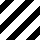
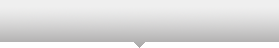
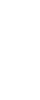
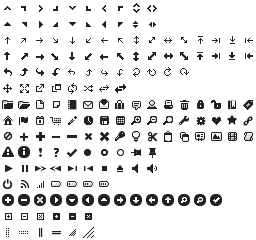
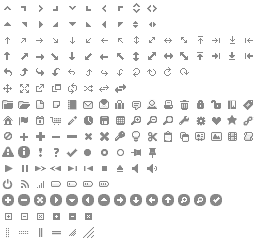
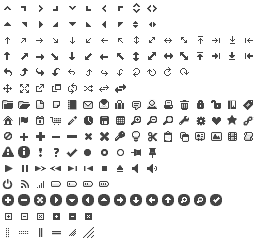
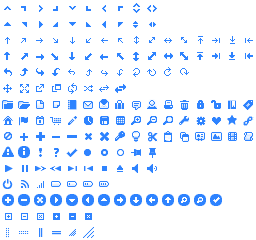
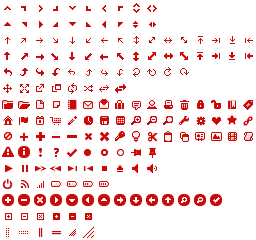
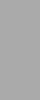
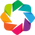
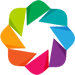
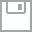
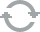
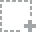
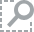
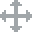
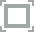
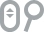

/Users/mmngreco/anaconda/envs/py3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [138]:
import bokeh.plotting as bkh
from bokeh import mpl

bkh.output_notebook()

ppl.plot(dwork.empleo, linewidth=3)
plt.xticks(dwork.index)
plt.legend(loc='upper left')
bkh.show(mpl.to_bokeh())

http://bokeh.pydata.org/en/latest/docs/reference/charts.html%23bokeh-charts

# GIT WORK-FLOW

In [106]:
datetime.now()

datetime.datetime(2015, 9, 15, 11, 40, 30, 506694)

In [107]:
%%!
git add .
git commit -a -m 'update 9.15.1140'
git push origin master

['[master cb67ab2] update 9.15.1140',
 ' 23 files changed, 3640 insertions(+), 6072 deletions(-)',
 ' create mode 100644 data_work/filtrado/max/data_hp.csv',
 ' create mode 100644 data_work/filtrado/max/qt_data.csv',
 ' create mode 100644 data_work/filtrado/qt_empleo_2015-09-15_10:40:26.289661.xls',
 ' create mode 100644 data_work/filtrado/qt_paro_2015-09-15_10:40:26.289661.xls',
 ' create mode 100644 data_work/filtrado/qt_pib_2015-09-15_10:40:26.289661.xls',
 ' create mode 100644 imgs/boxplot_HP-FILTER_2015-09-15_10:40:26.289661.png',
 ' create mode 100644 imgs/boxplot_QT-FILTER_2015-09-15_10:40:26.289661.png',
 ' create mode 100644 imgs/corr_HP-FILTER_2015-09-15_10:40:26.289661.png',
 ' create mode 100644 imgs/evolucion_hp-filter_pib_b0_2015-09-15_10:40:26.289661.png',
 ' create mode 100644 imgs/evolucion_hp-filter_pib_b0_2015-09-15_10:40:26.289661_todas.png',
 ' create mode 100644 imgs/evolucion_hp-filter_pib_b1_2015-09-15_10:40:26.289661.png',
 ' create mode 100644 imgs/evolucion_h